This Notebook is meant to explore the data and train a simple forecasting model on it.

In [1]:
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import figure
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import minmax_scale

In [2]:
# Load data directly from source into memory
data_src = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/vic_elec.csv'

data = pd.read_csv(data_src, sep=',', parse_dates=['Time', 'Date'],
                   dtype={'Demand': 'float32', 'Temperature': 'float32'})
data = data.set_index('Time').resample('1H', label='left').mean(numeric_only=False)

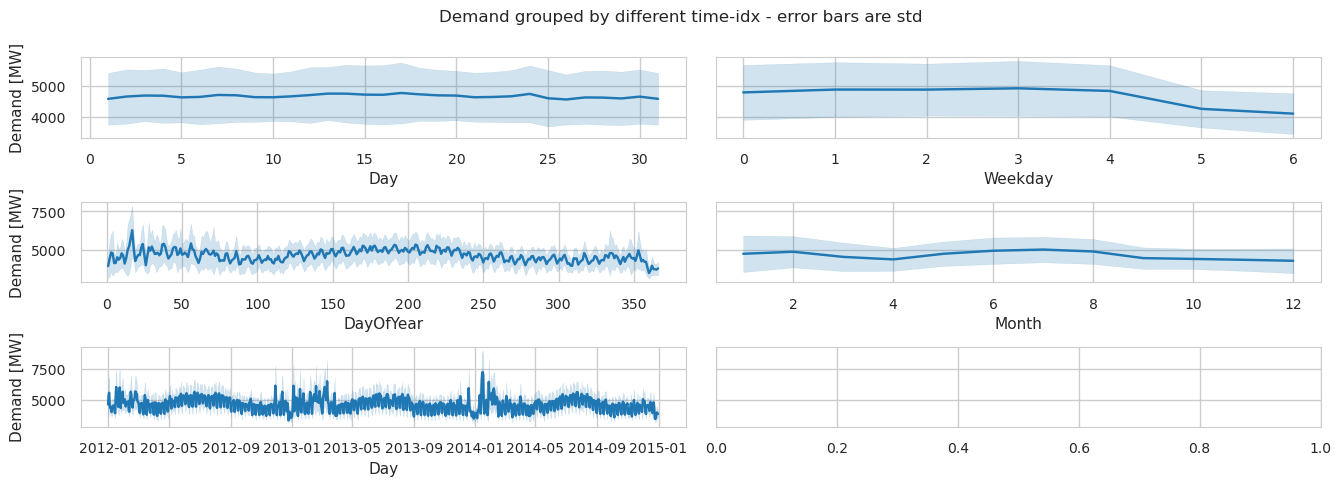

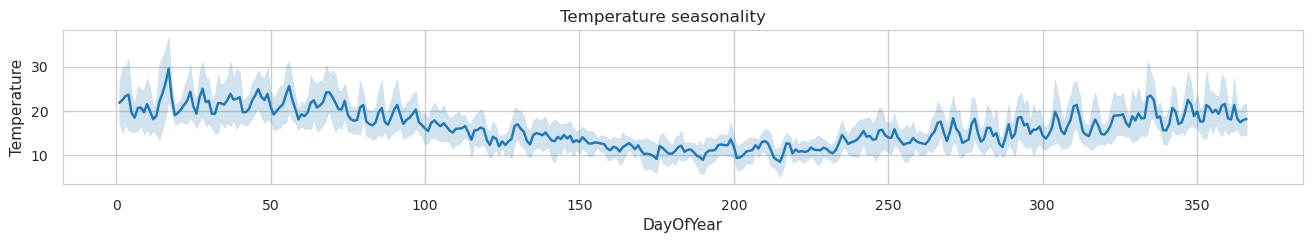

In [3]:
# Plot demand vs different time groups

date = data['Date'].dt

time_groups = [('Day', date.day),
               ('Weekday', date.weekday),
               ('DayOfYear', date.dayofyear),
               ('Month', date.month),
               ('Day', data['Date']),
               ]

with plt.style.context(['seaborn-v0_8-notebook']):
    fig, axn = plt.subplots(int(np.ceil(len(time_groups) / 2)), 2, sharey='row', figsize=figure.figaspect(.3))
    for ax, (x_name, x) in zip(axn.flat, time_groups):
        sns.lineplot(data=data, x=x, y='Demand', errorbar='sd', ax=ax)
        ax.set(xlabel=f'{x_name}', ylabel='Demand [MW]')

    fig.subplots_adjust(hspace=0.8, wspace=0.05)
    fig.suptitle('Demand grouped by different time-idx - error bars are std')

    plt.show()

    fig, ax = plt.subplots(figsize=figure.figaspect(0.1))
    sns.lineplot(data=data, x=data['Date'].dt.dayofyear, y='Temperature', ax=ax, errorbar='sd')
    ax.set(xlabel='DayOfYear')
    fig.suptitle('Temperature seasonality')

    plt.show()

In [4]:
# linear trend analysis

trend_dict = dict()
for target_name in ['Demand', 'Temperature']:
    X = np.arange(len(data))[:, np.newaxis]
    y = minmax_scale(data[[target_name]], feature_range=(0, 1))

    model_lr = LinearRegression()
    model_lr.fit(X, y)

    trend_dict[target_name] = model_lr.coef_[0][0]

print('Normalized trends:', trend_dict)

Normalized trends: {'Demand': -1.7713266049187333e-06, 'Temperature': -7.426034839263157e-07}


In [5]:
# Enrich dataset with new features

# add daylight saving time
dst = data.index.to_series().dt.tz_convert(tz='Australia/Victoria').apply(
    lambda ts: ts.dst().total_seconds() // (60 * 60))
data['DST'] = dst

data['Weekday'] = data['Date'].dt.weekday
data['Weekend'] = data['Weekday'].isin([6, 7])
data['DayOfYear'] = data['Date'].dt.dayofyear
data['TomorrowIsWeekend'] = data['Weekday'].isin([5, 6])
data['Hour_UTC'] = data.index.hour


def shift_vars(df: pd.DataFrame, var_name: str, hour_shift_list: np.ndarray,
               target_prefix: Optional[str] = None):
    shifts = list()

    df = df[[var_name]]

    if target_prefix is None:
        target_prefix = var_name

    def shift_symbol(period):
        if period < 0:
            return ''
        else:
            return '+'

    for hour_shift in hour_shift_list:
        shift = df[var_name].shift(periods=hour_shift)
        shift.name = f'{target_prefix}{shift_symbol(hour_shift)}{hour_shift:03d}'
        shifts.append(shift)
    return pd.concat(shifts, axis=1)


n_lag_days = 2

holiday_future = shift_vars(data, 'Holiday', np.arange(1, 25) * -1, 'Target-Holiday')
demand_lagged = shift_vars(data, 'Demand', np.arange(24 * n_lag_days))
temperature_lagged = shift_vars(data, 'Temperature', np.arange(24 * n_lag_days))
holiday_lagged = shift_vars(data, 'Holiday', np.arange(24 * n_lag_days))

features = pd.concat(
    [data[['Weekday', 'Weekend', 'Hour_UTC', 'DayOfYear']], holiday_future, demand_lagged, temperature_lagged,
     holiday_lagged], axis=1)

target = shift_vars(data, 'Demand', np.arange(1, 25) * -1)

In [6]:

drop_idx = target.isna().any(axis=1) | features.isna().any(axis=1)
drop_idx = drop_idx[drop_idx].index

features = features.drop(drop_idx)
target = target.drop(drop_idx)


In [7]:
# Cross-validate RandomForest model
meth_list = [('r2', metrics.r2_score),
             ('mae', metrics.mean_absolute_percentage_error),
             ('mse', metrics.mean_squared_error),
             ('mae', metrics.mean_absolute_percentage_error),
             ]

tscv = TimeSeriesSplit(n_splits=3)

model_list = list()
raw_score_list = list()
avg_score_list = list()

for train_idx, val_idx in tscv.split(features, target):
    y_train = target.iloc[train_idx]
    x_train = features.iloc[train_idx]

    x_val = features.iloc[val_idx]
    y_val = target.iloc[val_idx]

    model = RandomForestRegressor(n_jobs=-1)
    model.fit(x_train, y_train)


    def compute_metric_res(x, y):
        y_hat = model.predict(x)

        avg_score_res = dict()
        raw_score_res = dict()
        for met_name, met_fn in meth_list:
            score = met_fn(y, y_hat, multioutput='raw_values')
            avg_score_res[met_name] = score.mean()
            raw_score_res[met_name] = score
        return avg_score_res, raw_score_res


    avg_train, raw_train = compute_metric_res(x_train, y_train)
    avg_val, raw_val = compute_metric_res(x_val, y_val)

    avg_score_list.append(dict(train=avg_train,
                               val=avg_val))
    raw_score_list.append(dict(train=raw_train,
                               val=raw_val))
    model_list.append(model)


In [8]:
# print average predictions scores

for res in avg_score_list:
    for step in res:
        print(step, '\t', res[step], end='\n')
    print()

train 	 {'r2': 0.9907837726879208, 'mae': 0.010942138103443584, 'mse': 6576.374868094829}
val 	 {'r2': 0.8030996727272872, 'mae': 0.05733960992906414, 'mse': 164274.7252377627}

train 	 {'r2': 0.9880129076487224, 'mae': 0.012514631804410065, 'mse': 9383.791764323432}
val 	 {'r2': 0.8260728552560371, 'mae': 0.04773264228409366, 'mse': 145896.04558846875}

train 	 {'r2': 0.9873332746783481, 'mae': 0.012930527369227207, 'mse': 10216.312139722599}
val 	 {'r2': 0.9177436422472965, 'mae': 0.034294727416557085, 'mse': 49374.20029187398}



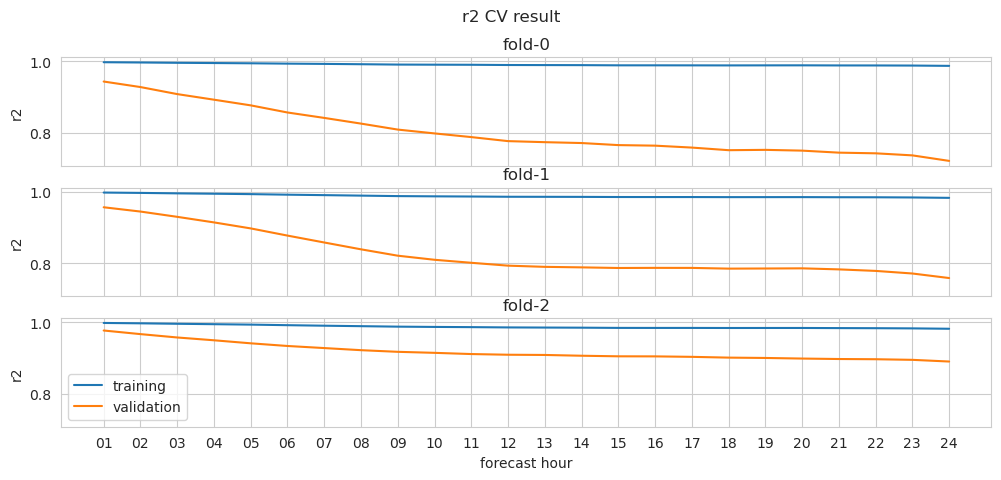

In [9]:
# The model clearly overfits, but does a reasonable job.
# Next let's investigate the r2 for each individual hour prediction.
# I suppose the r2 drops towards hour 24
plt.close('all')
fig, axn = plt.subplots(3, 1, figsize=figure.figaspect(0.4), sharex='all', sharey='all')
x = list(map(lambda n: n.split('-')[1],target.columns.to_list()))
for fold_idx, (raw_score, ax) in enumerate(zip(raw_score_list, axn)):

    sns.lineplot(x=x, y=raw_score['train']['r2'], ax=ax, label='training')
    sns.lineplot(x=x, y=raw_score['val']['r2'], ax=ax, label='validation')
    ax.get_legend().remove()
    ax.set(title=f'fold-{fold_idx}', ylabel='r2')

ax_ = axn[-1]
ax_.set(xlabel='forecast hour')
ax_.legend()

fig.suptitle('r2 CV result')
plt.show()

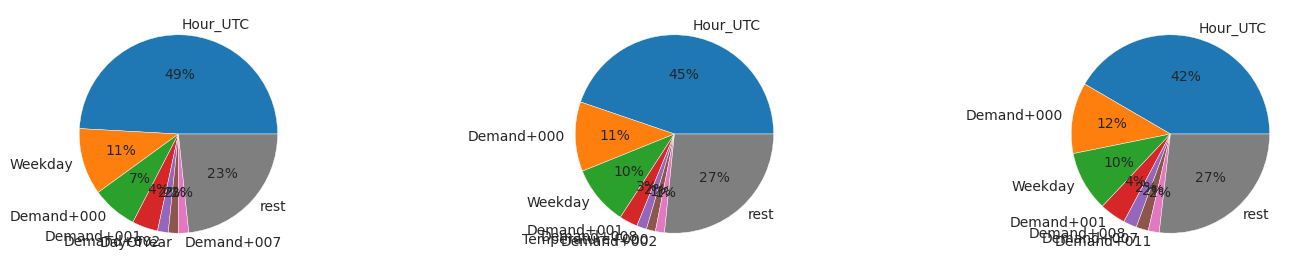

In [10]:
n_most_important = 8
with plt.style.context(['seaborn-v0_8-notebook']):
    fig, axn = plt.subplots(1, 3, figsize=figure.figaspect(.3))
    for model, ax in zip(model_list, axn.flat):
        imp_argsort = np.argsort(model.feature_importances_)
        fi = model.feature_importances_[imp_argsort[::-1]]
        labels = features.columns[imp_argsort[::-1]].tolist()
        fi[n_most_important - 1] = fi[n_most_important:].sum()
        labels[n_most_important - 1] = 'rest'

        colors = sns.color_palette()[:n_most_important]
        ax.pie(fi[:n_most_important], labels=labels[:n_most_important], colors=colors, autopct='%.0f%%')
    fig.subplots_adjust(wspace=1)
    plt.show()